In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import copy
from image_matrix_helper import compute_master_list, imshow_list, rgb_map
import random
import time

nb_start = time.time()

## Hints at Non-Equilibrium Behavior

In this notebook, we again simulate the systems presented in `search_and_combinatorics.ipynb`, but we do so in order to see how the number of correctly placed particles evolves towards its equilibrium value over the course of the simulation.

We will use much of the code from that section so we copy it here without additional explanation

#### Parameter function definitions

In [2]:
# helper function definitions
gamma_func = lambda E0, Ev, T: 4*np.sqrt(2)*np.exp(E0/T)*(Ev/T)**(3/2)
delta_func = lambda Del, T: np.exp(Del/T)
phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta) 

#### Microstate transitions

In [3]:
## dissociation operator
def trans_dissoc(free_objs, bound_objs):
        
        # indices of non-empty
        indxs = [i for i, x in enumerate(bound_objs) if x != "-"]
        
        # random choice for bound object
        random_indx = random.choice(indxs)

        ## new state vector 
        free_objs_new = copy.deepcopy(free_objs)
        bound_objs_new = copy.deepcopy(bound_objs)

        # putting empty slot
        bound_objs_new[random_indx] = '-'
        # appending previously bound object to free objects
        free_objs_new.append(bound_objs[random_indx])

        return free_objs_new, bound_objs_new


## association operator
def trans_assoc(free_objs, bound_objs):
    
        # random element to associate
        elem = random.choice(free_objs)

        # indices of empty spaces
        indxs = [i for i, x in enumerate(bound_objs) if x == "-"]  

        # random choice for empty space
        random_indx = random.choice(indxs)

        ## new state vector 
        free_objs_new = copy.deepcopy(free_objs)
        bound_objs_new = copy.deepcopy(bound_objs)    

        ## state
        free_objs_new.remove(elem)
        bound_objs_new[random_indx] = elem      

        return free_objs_new, bound_objs_new

## permutation operator
def trans_perm(free_objs, bound_objs):
    
    Ncomp = len(bound_objs)
    i1 = int(random.choice(range(Ncomp)))
    i2 = int(random.choice(range(Ncomp)))

    ## new omega vector 
    bound_objs_new = copy.deepcopy(bound_objs)
    bound_objs_new[i2] = bound_objs[i1]
    bound_objs_new[i1] = bound_objs[i2]
    
    return free_objs, bound_objs_new

#### Logarithm of Botlzmann factor

The logarithm of the Botlzmann factor for a microstate (i.e., the temperature normalized negative energy of the microstate) is defined as 

\begin{equation}
\beta E(\boldsymbol{k}, \boldsymbol{m}) = \sum_{i=1}^R(m_i \ln \delta_i + k_i \ln \gamma_i).
\label{eq:sim_en}
\end{equation}

In [4]:
def log_boltz(free_objs, bound_objs, mstr_vec, deltas, gammas, name_key):
    
    elem_set = list(set(mstr_vec))
    count_dict = dict()
    for elem in elem_set:
        count_dict[elem] = bound_objs.count(elem)

    bind_log_factor = 0
    for elem in elem_set:
        key = name_key[elem]
        bind_log_factor += count_dict[elem]*np.log(gammas[key])
        
        
    corr_log_factor = 0
    for j in range(len(bound_objs)):
        if bound_objs[j] == mstr_vec[j]:
            elem = bound_objs[j]
            key = name_key[elem]
            corr_log_factor+=np.log(deltas[key])        
    
    return bind_log_factor+corr_log_factor    

#### Function to count the number of correctly bound particles

In [5]:
def m_calc(bound_objs, mstr_vec):
    
    num = 0
    for k in range(len(mstr_vec)):
        if mstr_vec[k] == bound_objs[k]:
            num += 1
    return num

#### Metropolis Hastings algorithm

In [6]:
### Metropolis Monte Carlo Algorithm 

## loads uniform random sampling 
runif = np.random.rand

def met_assembly_grid(Niter, free_objs, bound_objs, mstr_vec, deltas, gammas, name_key, only_physical_trans = False):
    '''
    #################################################################
    # function to sample using Metropolis 
    #  
    # n_iter:  number of iterations
    # initial_state: initial state for the start position for our chain
    # gamma: energy cost for incorrect component
    # temp: temperature 
    ##################################################################
    '''
    
    # Initialize state values
    free_objs_vals = [0]*(Niter+1)
    bound_objs_vals = [0]*(Niter+1)
    
    # Set initial values
    free_objs_vals[0] = free_objs[:]
    bound_objs_vals[0] = bound_objs[:]
        
    # Initialize acceptance counts
    # We can use this to tune our number of steps
    accepted = 0
    
    # debugging code
    debug_assoc, debug_dissoc, debug_perm = 0, 0, 0
    
    for i in range(Niter):
    
        # get current monomer and dimer states
        current_free_objs = copy.deepcopy(free_objs_vals[i])
        current_bound_objs = copy.deepcopy(bound_objs_vals[i])
        
        N_free = len(current_free_objs)
        N_bound = len(current_bound_objs)-len(current_free_objs)
        
        u_trans = runif()
        
        # only allow for physical transitions
        if only_physical_trans: 
            u1, u2 = 1/2, 1
        # includes permutation transition
        else:
            u1, u2 = 1/3, 2/3
        
        if u_trans < u1: #first type of transition; monomer association 
            
            if N_free < 1:
                
                log_alpha = np.log(1e-15) 
            
            else:
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_assoc(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, deltas, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, deltas, gammas, name_key)

                # weight
                num = N_free*N_free
                den = N_bound+1

                # Log-acceptance rate
                log_alpha = log_final-log_init+np.log(num/den) 
            
        elif u1 <= u_trans < u2: #second type of transition; bound monomer dissociation
            
            if N_bound <1:
                
                log_alpha = np.log(1e-15) 
                
            else: 
                
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_dissoc(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, deltas, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, deltas, gammas, name_key)

                # weight
                num = N_bound 
                den = (N_free+1)*(N_free+1)   

                # Log-acceptance rate
                log_alpha = log_final-log_init+np.log(num/den) 
            
        elif u2 <= u_trans: #third type of transition; switching bounded elements
            
            if N_bound <2:
                
                log_alpha = np.log(1e-15) 
            
            else:
                
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_perm(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, deltas, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, deltas, gammas, name_key)

                # Log-acceptance rate
                log_alpha = log_final-log_init
            
        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < log_alpha:
            # Accept
            free_objs_vals[i+1] = new_free_objs
            bound_objs_vals[i+1] = new_bound_objs
            
            #log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            free_objs_vals[i+1] = free_objs_vals[i]
            bound_objs_vals[i+1] = bound_objs_vals[i]

    # return our samples and the number of accepted steps
    return free_objs_vals, bound_objs_vals, accepted

#### Image grid for completely correct configuration

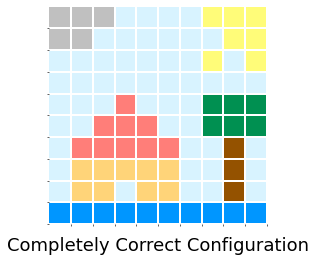

In [7]:
# defining master_list
master_list =compute_master_list()
# testing plot
imshow_list(master_list, title = 'Completely Correct Configuration');
# defining Nelems
Nelems = np.zeros(8)
key_list = list(rgb_map.keys())[:-1]
name_key_ = dict()
for j in range(len(key_list)):
    name_key_[key_list[j]] = j
    Nelems[j] = master_list.count(key_list[j])

In [8]:
# displaying copy-number counts of the various elements
Nelems

array([ 9.,  9., 10.,  5.,  7.,  6.,  3., 51.])

#### Simulating system

In [9]:
# whether to only include physical transitions
only_physical_trans = True

# starting time
t0_start = time.time()

# setting parameter dictionary
param_dict = {'Search Limited': {'Del_bar':7.7501 , 
                                 'sigma_D':2.0, 
                                 'E0_bar':3.0, 
                                 'sigma_E':1.0},
              'Combinatorics Limited':{'Del_bar': 4.75, 
                                 'sigma_D': 2.0, 
                                 'E0_bar': 16.0, 
                                 'sigma_E':3.0}, 
              'Indeterminate': {'Del_bar': 6.75, 
                                 'sigma_D': 2.0, 
                                 'E0_bar': 10.75, 
                                 'sigma_E': 3.0}, }


# dictionary that contains both physical and unphysical transitions
m_full_data_dict = defaultdict(dict) 

num_trajs = 10 # number of trajectories to plot for each data set

for bool_ in [True, False]:
    
    # defining whether to include only physical transitions
    only_physical_trans = bool_    

    # empty list of list of trajectories
    bound_list_dict = {'Search Limited': [[]]*num_trajs,
                  'Combinatorics Limited':[[]]*num_trajs, 
                  'Indeterminate':[[]]*num_trajs }

    # number of steps for MC algortihm
    Nmc = 10000

    # initial monomer and dimer states; 
    # system in microstate of all correct dimers
    random.seed(0)
    free_objs_0 = random.sample(master_list, len(master_list))
    bound_objs_0 = ['-']*len(master_list) 
    mstr_vec = copy.deepcopy(master_list)

    # make copy of initial monomer and dimer states 
    free_objs_copy = copy.deepcopy(free_objs_0)
    bound_objs_copy = copy.deepcopy(bound_objs_0)

    # temperature set    
    T0 = 0.5

    for type_ in list(bound_list_dict.keys()):

        # start time for particular type
        t0 = time.time()      

        # getting parameter values
        dict_vals = param_dict[type_]

        # drawing energy values
        np.random.seed(24)
        R=8
        Del_bar, sigma_D = dict_vals['Del_bar'], dict_vals['sigma_D']
        Dels = np.random.randn(R)*sigma_D+Del_bar
        E0_bar, sigma_E = dict_vals['E0_bar'], dict_vals['sigma_E']
        E0s = np.random.randn(R)*sigma_E+E0_bar 
        Evs = np.ones(R)*0.001

        # defining helper functions
        gammas_ = gamma_func(E0s, Evs, T0)
        deltas_ = delta_func(Dels, T0)  


        for k in range(num_trajs):
            # metroplois generator
            _, bound_list_dict[type_][k], _ = met_assembly_grid(Nmc, 
                                                                free_objs_copy,
                                                                bound_objs_copy,
                                                                mstr_vec,
                                                                deltas_,
                                                                gammas_,
                                                                name_key_, 
                                                               only_physical_trans=only_physical_trans) 

            t_prelim = time.time()
            print("Temperature Run:",str(k+1),"; Current Time:", round(t_prelim-t0,2),"secs")


        t1 = time.time()
        print(f"\nTotal Simulation Run Time for {type_}: {round(t1-t0,2)} secs")
        print("----------\n") 

    # copying data    
    m_full_data_dict[only_physical_trans] = bound_list_dict
    t2 = time.time()    
    print("------------------------------\n------------------------------")   
    print(f"Total Simulation Run Time for Only Physical Trans = {only_physical_trans}: {round(t2-t0_start,2)} secs")      


t3 = time.time()    
print("------------------------------\n------------------------------")   
print(f"Total Simulation Run Time for all: {round(t2-t0_start,2)} secs")    

Temperature Run: 1 ; Current Time: 3.77 secs
Temperature Run: 2 ; Current Time: 7.26 secs
Temperature Run: 3 ; Current Time: 10.92 secs
Temperature Run: 4 ; Current Time: 15.27 secs
Temperature Run: 5 ; Current Time: 20.33 secs
Temperature Run: 6 ; Current Time: 24.63 secs
Temperature Run: 7 ; Current Time: 29.11 secs
Temperature Run: 8 ; Current Time: 32.96 secs
Temperature Run: 9 ; Current Time: 36.75 secs
Temperature Run: 10 ; Current Time: 41.17 secs

Total Simulation Run Time for Search Limited: 41.17 secs
----------

Temperature Run: 1 ; Current Time: 2.07 secs
Temperature Run: 2 ; Current Time: 4.06 secs
Temperature Run: 3 ; Current Time: 6.02 secs
Temperature Run: 4 ; Current Time: 8.54 secs
Temperature Run: 5 ; Current Time: 10.64 secs
Temperature Run: 6 ; Current Time: 12.97 secs
Temperature Run: 7 ; Current Time: 14.92 secs
Temperature Run: 8 ; Current Time: 16.97 secs
Temperature Run: 9 ; Current Time: 19.03 secs
Temperature Run: 10 ; Current Time: 21.1 secs

Total Simulati

#### Plotting simulated values of $m/N$ for each system type

In [10]:
# dictionary that contains both physical and unphysical transitions
m_t_full_data_dict = defaultdict(dict) 

# dictionary for final values of m/N
m_t_dict = {'Search Limited': [[]]*num_trajs,
              'Combinatorics Limited':[[]]*num_trajs, 
              'Indeterminate':[[]]*num_trajs }

In [11]:
for bool_ in [True, False]:
    
    # defining whether to include only physical transitions
    only_physical_trans = bool_    
    
    # getting list of bound states
    bound_list_dict = m_full_data_dict[only_physical_trans]

    # dictionary for final values of m/N
    m_t_dict = {'Search Limited': [[]]*num_trajs,
                  'Combinatorics Limited':[[]]*num_trajs, 
                  'Indeterminate':[[]]*num_trajs }

    # filling in dictionary values for m/N
    for type_ in list(m_t_dict.keys()):
        m_t_dict[type_] = [[m_calc(elem, master_list)/(len(master_list)) for elem in bound_list_dict[type_][k]] for k in range(num_trajs)]

    # dictionary for values of m/N 
    m_t_full_data_dict[bool_] = m_t_dict  

Only Physical Transitions: True
System Type: Search Limited



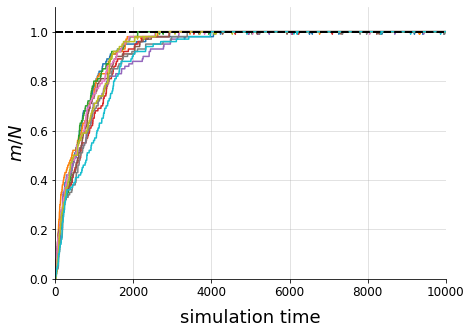

Only Physical Transitions: True
System Type: Combinatorics Limited



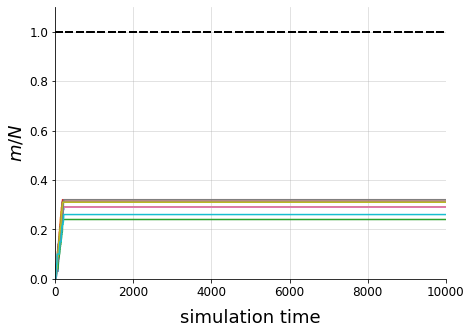

Only Physical Transitions: True
System Type: Indeterminate



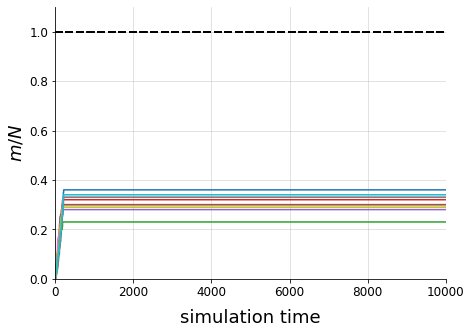

Only Physical Transitions: False
System Type: Search Limited



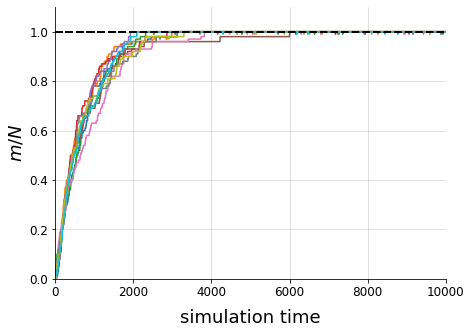

Only Physical Transitions: False
System Type: Combinatorics Limited



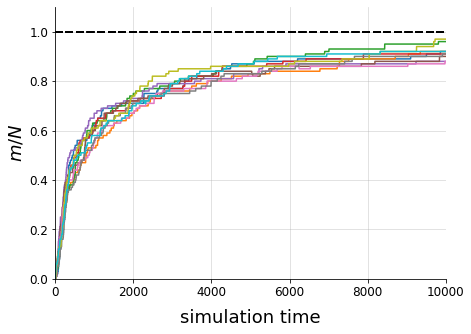

Only Physical Transitions: False
System Type: Indeterminate



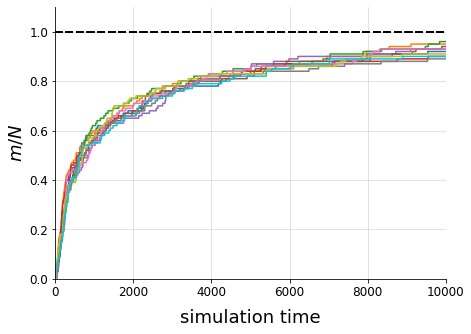

In [12]:
for bool_ in [True, False]:
    
    # getting dictionary value for particular transition type
    m_t_dict = m_t_full_data_dict[bool_]
    
    for type_ in list(m_t_dict.keys()):

        plt.figure(figsize = (7,5))
        ax = plt.subplot(111)

        for k in range(num_trajs):
            plt.plot(m_t_dict[type_][k])

            # plot formatting
            ax.set_xlabel(r'simulation time', fontsize = 18,labelpad=10)
            plt.xlim([0, 10000])
            plt.ylim([0,1.1])
            plt.ylabel(r'$m/N$', fontsize = 18)
            # plt.yaxis.set_label_coords(-0.1,.5)

            ax.axhline(y = 1.0, color = 'k', linestyle = 'dashed', linewidth = 2)


            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            # Only show ticks on the left and bottom spines
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')

            # increase label size
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.tick_params(axis='both', which='minor', labelsize=12)    
            # plt.legend(loc = 'best', fontsize = 12)

        plt.grid(alpha = 0.45)  
        type_name = type_.replace(' ', '_').lower()
        print('Only Physical Transitions:', bool_)
        print('System Type:', type_)
        print()

    #     if only_physical_trans:
    #         suffix = 'phys'
    #     else:
    #         suffix = 'nonphys'
    #     plt.savefig(f'hints_neqbm_{suffix}_{type_name}.png', bbox_inches='tight', format = 'png')

        plt.show()    

In [13]:
print('Total Notebook Runtime: %.3f mins' % ((time.time()-nb_start)/60))

Total Notebook Runtime: 3.502 mins
